## Setup, Loading Data and CDFs

In [4]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'gray'

In [5]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_vertical_wavelet_indoor_coco.ipynb


In [6]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/vertical/gray'

In [7]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [8]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [9]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


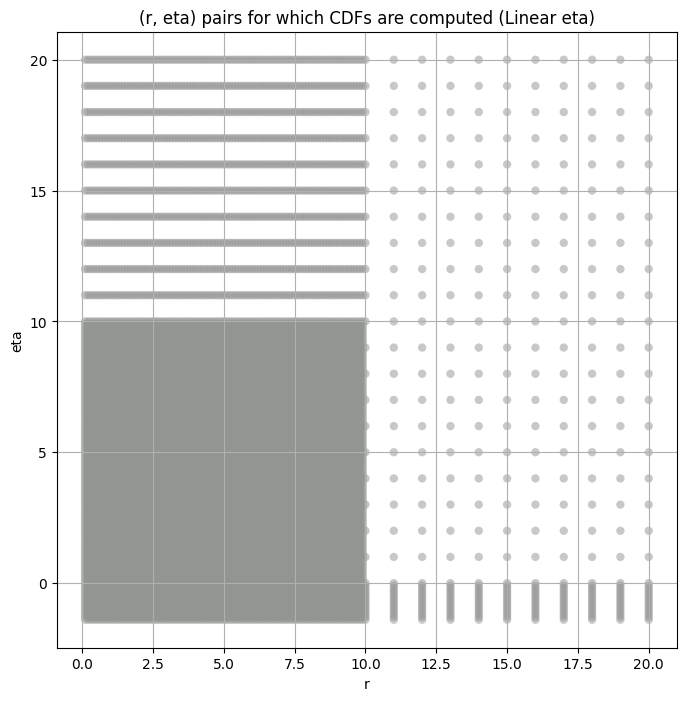

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [10]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [11]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [12]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:35<00:00, 2781.06it/s]


Layer 3


100%|██████████| 100000/100000 [00:42<00:00, 2361.04it/s]


Layer 4


100%|██████████| 100000/100000 [00:47<00:00, 2113.76it/s]


Layer 5


100%|██████████| 100000/100000 [04:44<00:00, 351.93it/s]


Layer 6


100%|██████████| 100000/100000 [13:18<00:00, 125.17it/s]


Layer 7


100%|██████████| 100000/100000 [01:14<00:00, 1338.29it/s]


Layer 8


100%|██████████| 100000/100000 [01:16<00:00, 1305.14it/s]


Layer 9


100%|██████████| 100000/100000 [01:10<00:00, 1410.67it/s]


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.873965e+07  1.663401e+07  2.101433e+07   1.273592    0.505800   
3      4.449792e+06  4.165360e+06  4.741460e+06   2.060963    1.628771   
4      9.473083e+05  8.903944e+05  1.005686e+06   3.505688    2.952087   
5      1.869647e+05  1.740690e+05  2.004473e+05   5.608747    4.736248   
6      3.371252e+04  3.086009e+04  3.671613e+04   9.509533    7.824300   
7      5.919651e+03  5.323679e+03  6.567964e+03  14.504868   11.675694   
8      1.124672e+03  9.873868e+02  1.276368e+03  22.566565   17.524040   
9      2.439054e+02  2.100613e+02  2.812192e+02  30.251938   22.803614   

       kurt_upper  total_samples  
layer                             
2        2.174329         1604.0  
3        2.520827         6416.0  
4        4.137850        25664.0  
5        6.600736       102656.0  
6       11.492226       410624.0  
7       18.431257      1642496.0  
8       29.029783      6569984.0  
9       40.821050     26279936.0

## Initial Grid Search and Hypothesis Test Plots

In [13]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [14]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      1.873965e+07   1.873965e+07    1.420482e+07    1.204765e+07   
3      4.449792e+06   4.449792e+06    3.959554e+06    3.658305e+06   
4      9.473083e+05   9.473083e+05    9.013071e+05    8.689891e+05   
5      1.869647e+05   1.869647e+05    1.831234e+05    1.801488e+05   
6      3.371252e+04   3.371252e+04    3.269079e+04    3.194055e+04   
7      5.919651e+03   5.919651e+03    5.683293e+03    5.515721e+03   
8      1.124672e+03   1.124672e+03    1.062726e+03    1.019695e+03   
9      2.439054e+02   2.439054e+02    2.274442e+02    2.162240e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.041067e+07     9.082016e+06     7.077530e+06     5.525639e+06   
3        3.421329e+06     3.218716e+06     2.880798e+06     2.598578e+06   
4        8.417268e+05     8.175224e+05     7.754098e+05     7.395916e+05   
5        1.775335e+05     1.751490e+05     1.708821e+05     1.670949e+05   
6        3.130041e+04     3.072913e+04     2.973128e+04     2.885783e+04   
7        5.372205e+03     5.245535e+03     5.026245e+03     4.837320e+03   
8        9.842911e+02     9.536824e+02     9.016895e+02     8.579351e+02   
9        2.070670e+02     1.992170e+02     1.861261e+02     1.753649e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         4.310718e+06     3.357991e+06     2.579900e+06     9.976886e+05  
3         2.363241e+06     2.167164e+06     1.997670e+06     1.595935e+06  
4         7.082914e+05     6.804950e+05     6.554304e+05     5.916092e+05  
5         1.636952e+05     1.605614e+05     1.576247e+05     1.496986e+05  
6         2.807652e+04     2.736562e+04     2.670842e+04     2.498226e+04  
7         4.669597e+03     4.518212e+03     4.379947e+03     4.025006e+03  
8         8.199612e+02     7.862759e+02     7.559474e+02     6.795316e+02  
9         1.661795e+02     1.581585e+02     1.510435e+02     1.335763e+02

####
Layer  2


100%|██████████| 12760/12760 [00:02<00:00, 5117.53it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.01179801592554236 18739654.0


100%|██████████| 12760/12760 [00:01<00:00, 7289.08it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.03044694589345079 14204823.0


100%|██████████| 12760/12760 [00:01<00:00, 7824.98it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.046424692596387734 12047654.0


100%|██████████| 12760/12760 [00:01<00:00, 7891.71it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.05952282431887345 10410673.0


100%|██████████| 12760/12760 [00:01<00:00, 7953.34it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.07334039874586777 9082016.0


100%|██████████| 12760/12760 [00:01<00:00, 7764.14it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.09889673691152476 7077530.0


100%|██████████| 12760/12760 [00:01<00:00, 7470.82it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.12594126906169792 5525639.0


100%|██████████| 12760/12760 [00:01<00:00, 7639.63it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.15171839224749367 4310718.5


100%|██████████| 12760/12760 [00:01<00:00, 7618.60it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.17424595674304194 3357990.8


100%|██████████| 12760/12760 [00:01<00:00, 7690.77it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.19978456947271217 2579900.0


100%|██████████| 12760/12760 [00:01<00:00, 7303.41it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.28072856956124864 997688.56
Number of samples: 1604, Without approximation : 1604.0


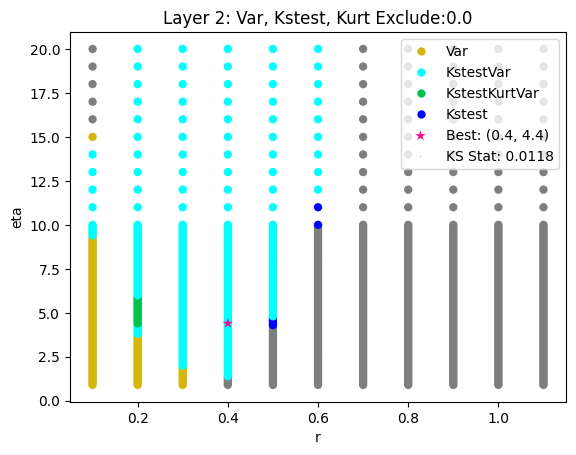

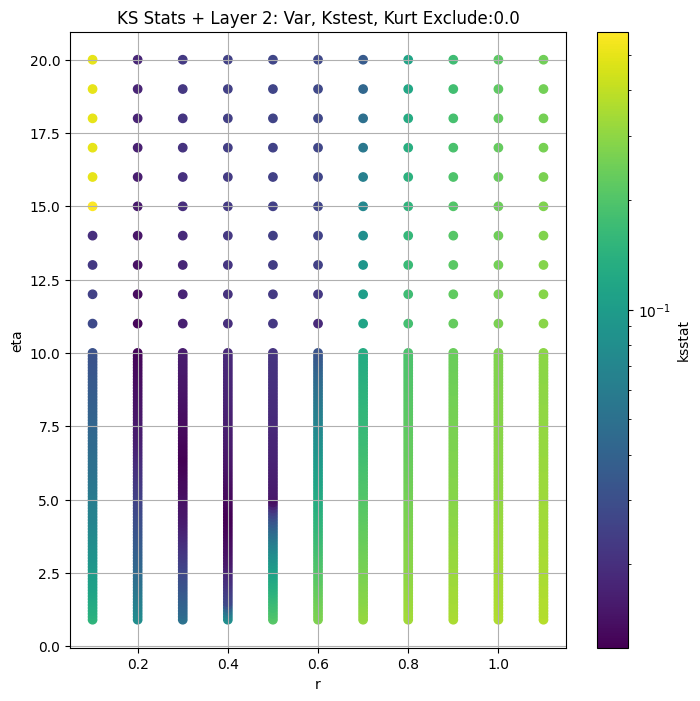

####
Layer  3


100%|██████████| 12760/12760 [00:04<00:00, 2930.27it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.01068655439052335 4449792.0


100%|██████████| 12760/12760 [00:04<00:00, 2877.43it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.015020666739502392 3959553.5


100%|██████████| 12760/12760 [00:04<00:00, 2945.48it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.017704984053194345 3658305.2


100%|██████████| 12760/12760 [00:04<00:00, 2940.40it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.020402690904725296 3421328.8


100%|██████████| 12760/12760 [00:04<00:00, 2961.98it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.023168490416164186 3218716.0


100%|██████████| 12760/12760 [00:07<00:00, 1632.77it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.031183509584232293 2880798.0


100%|██████████| 12760/12760 [00:04<00:00, 2784.17it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.04009407269515118 2598577.5


100%|██████████| 12760/12760 [00:04<00:00, 2753.50it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.048955134773761136 2363241.0


100%|██████████| 12760/12760 [00:05<00:00, 2307.46it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.05672836845800994 2167163.5


100%|██████████| 12760/12760 [01:16<00:00, 166.51it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.06355907957595833 1997669.8


100%|██████████| 12760/12760 [00:04<00:00, 2772.39it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.08167409114786159 1595935.2
Number of samples: 6416, Without approximation : 6416.0


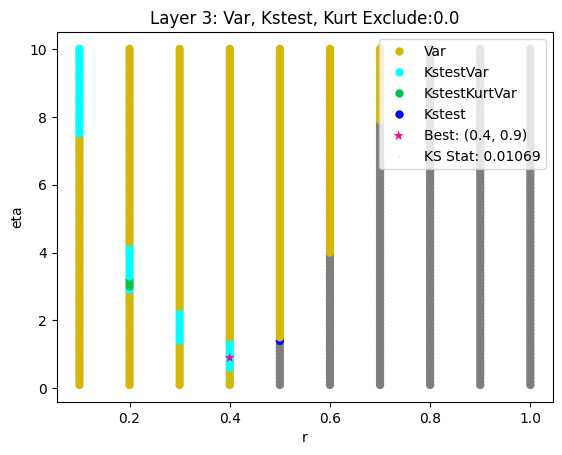

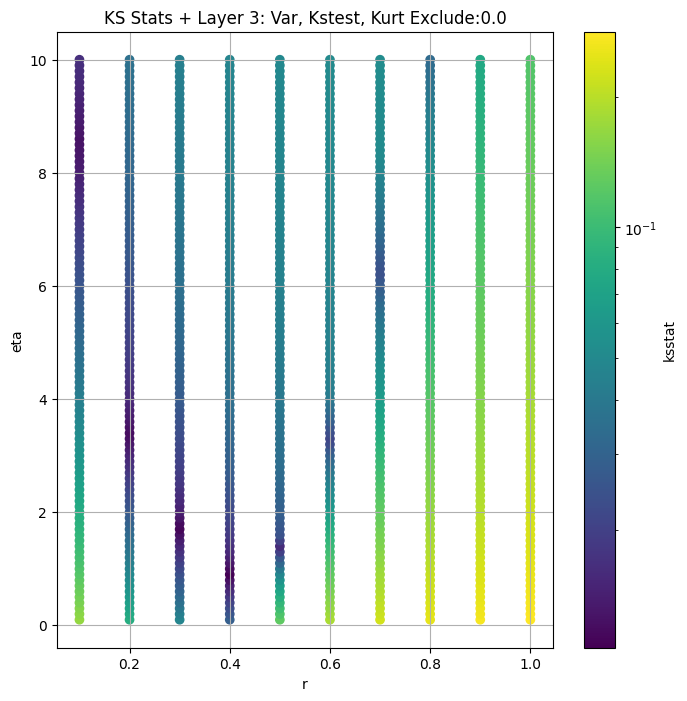

####
Layer  4


100%|██████████| 12760/12760 [01:04<00:00, 198.71it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.009794207382576303 947308.3


100%|██████████| 12760/12760 [00:24<00:00, 517.13it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.011894201167746643 901307.1


100%|██████████| 12760/12760 [00:16<00:00, 754.85it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.012215444150933896 868989.06


100%|██████████| 12760/12760 [00:15<00:00, 826.97it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.013371910333320303 841726.8


100%|██████████| 12760/12760 [00:28<00:00, 452.65it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.014499778729910151 817522.4


100%|██████████| 12760/12760 [00:23<00:00, 549.61it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.017329033766519064 775409.75


100%|██████████| 12760/12760 [00:23<00:00, 540.39it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.01939799062156078 739591.6


100%|██████████| 12760/12760 [00:16<00:00, 789.21it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.021473659383207555 708291.44


100%|██████████| 12760/12760 [00:23<00:00, 541.74it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.022924768931943618 680495.0


100%|██████████| 12760/12760 [00:43<00:00, 292.89it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.0247510528107191 655430.4


100%|██████████| 12760/12760 [00:47<00:00, 267.99it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.030396190121538047 591609.25
Number of samples: 25664, Without approximation : 25664.0


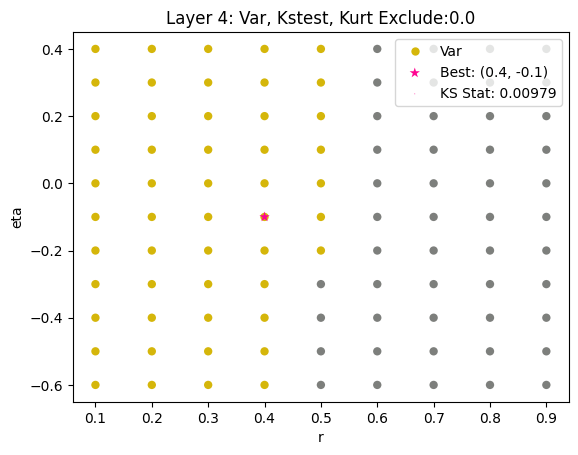

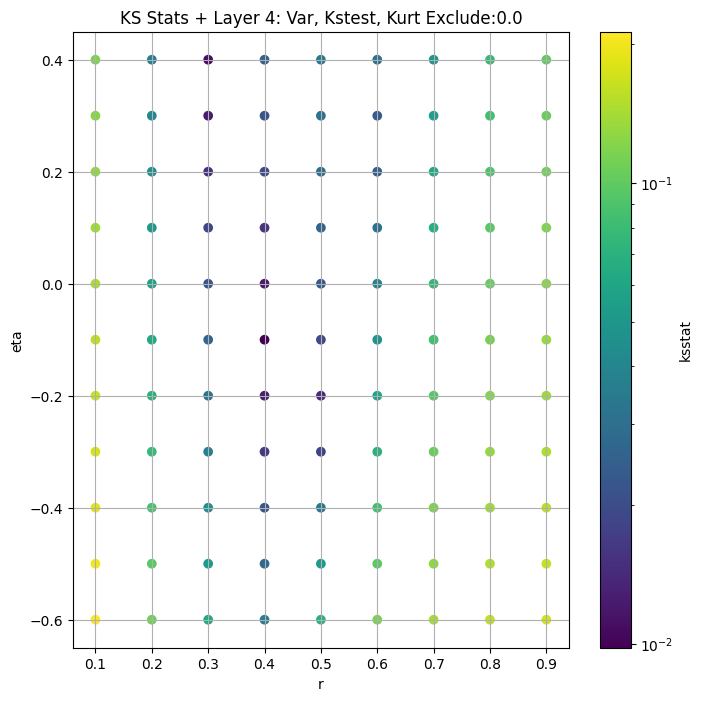

####
Layer  5


100%|██████████| 12760/12760 [14:25<00:00, 14.73it/s] 


Finding Minimum after computing 12760 CDFs
5 0 0.008674115719928877 186964.67


100%|██████████| 12760/12760 [00:56<00:00, 226.59it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.008687673593627543 183123.38


100%|██████████| 12760/12760 [00:56<00:00, 226.36it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.009615785500390106 180148.8


100%|██████████| 12760/12760 [37:33<00:00,  5.66it/s]  


Finding Minimum after computing 12760 CDFs
5 75 0.010439990473609773 177533.55


100%|██████████| 12760/12760 [00:59<00:00, 215.60it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.011198315393606384 175148.97


100%|██████████| 12760/12760 [01:02<00:00, 203.64it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.012596809515569407 170882.08


100%|██████████| 12760/12760 [00:59<00:00, 216.00it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.013857957807423826 167094.92


100%|██████████| 12760/12760 [00:57<00:00, 221.00it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.012929869277975292 163695.16


100%|██████████| 12760/12760 [00:57<00:00, 220.14it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.011941984680889695 160561.42


100%|██████████| 12760/12760 [01:02<00:00, 204.47it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.01294358596056322 157624.69


100%|██████████| 12760/12760 [01:04<00:00, 198.96it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.01586756307400805 149698.62
Number of samples: 100000, Without approximation : 102656.0


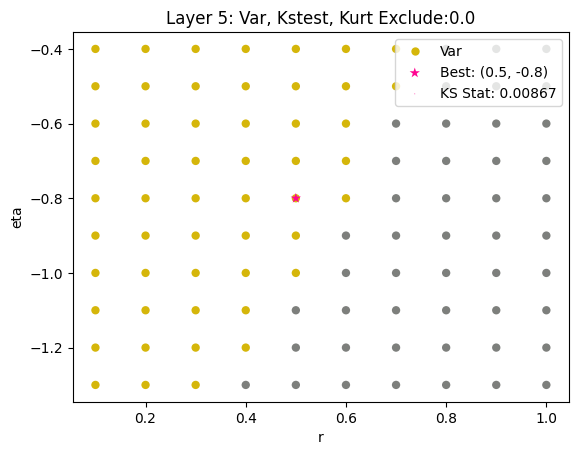

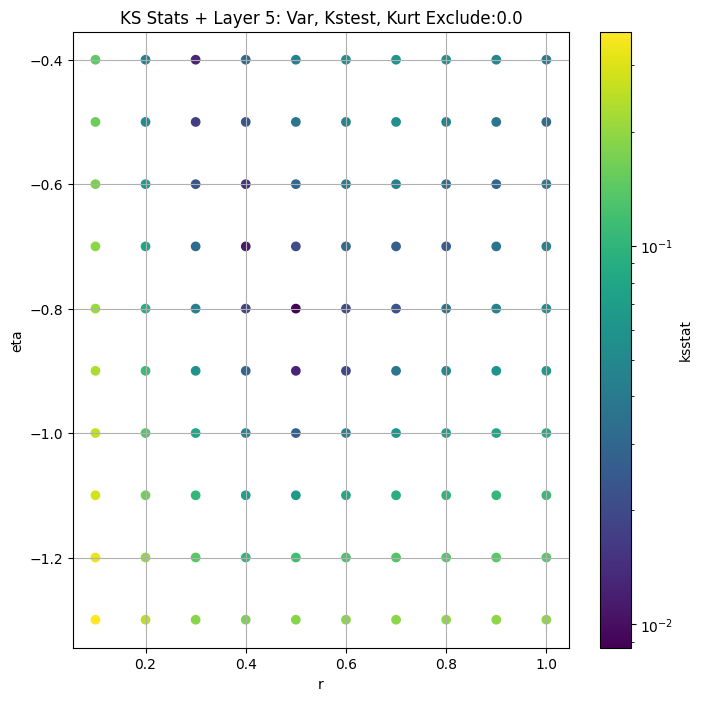

####
Layer  6


100%|██████████| 12760/12760 [00:58<00:00, 217.20it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.015339405897656755 33712.516


100%|██████████| 12760/12760 [01:05<00:00, 195.41it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.015226757697316962 32690.785


100%|██████████| 12760/12760 [01:01<00:00, 208.95it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.014886907133157712 31940.553


100%|██████████| 12760/12760 [01:00<00:00, 209.98it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.014159500051316276 31300.414


100%|██████████| 12760/12760 [01:00<00:00, 209.67it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.014473603832311999 30729.127


100%|██████████| 12760/12760 [00:58<00:00, 218.57it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.015042046512141916 29731.275


100%|██████████| 12760/12760 [00:57<00:00, 220.38it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.014990475680334236 28857.826


100%|██████████| 12760/12760 [00:58<00:00, 216.29it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.015181518908545771 28076.523


100%|██████████| 12760/12760 [00:57<00:00, 220.38it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.016498861110841312 27365.625


100%|██████████| 12760/12760 [00:57<00:00, 220.44it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.016933871322768912 26708.42


100%|██████████| 12760/12760 [00:58<00:00, 218.45it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.015304782936729933 24982.256
Number of samples: 100000, Without approximation : 410624.0


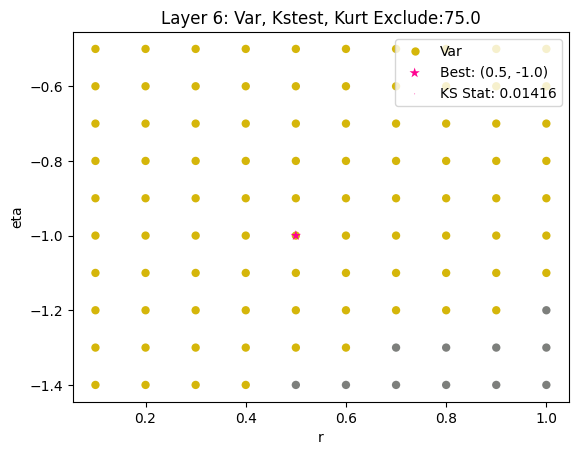

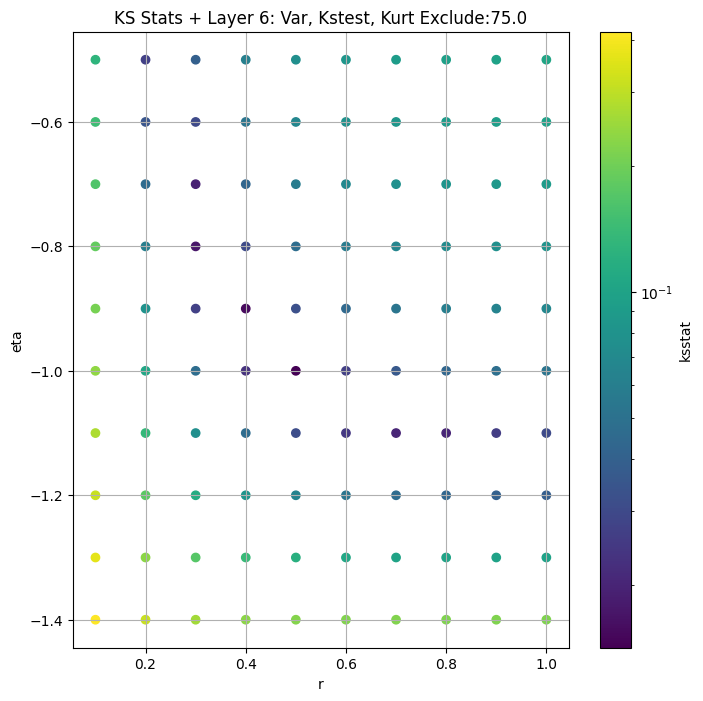

####
Layer  7


100%|██████████| 12760/12760 [00:57<00:00, 222.32it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.029390064015088646 5919.6514


100%|██████████| 12760/12760 [00:57<00:00, 221.09it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.02938224715913934 5683.2935


100%|██████████| 12760/12760 [00:59<00:00, 214.52it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.029376403489036418 5515.721


100%|██████████| 12760/12760 [00:57<00:00, 222.50it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.029533738170254897 5372.205


100%|██████████| 12760/12760 [00:59<00:00, 216.16it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.02953090266457231 5245.535


100%|██████████| 12760/12760 [00:58<00:00, 217.11it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.029525742771975172 5026.2446


100%|██████████| 12760/12760 [00:57<00:00, 222.53it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.029521018868353788 4837.3203


100%|██████████| 12760/12760 [00:59<00:00, 214.98it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.029405898625692928 4669.597


100%|██████████| 12760/12760 [00:57<00:00, 220.45it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.029399851453116188 4518.2124


100%|██████████| 12760/12760 [00:58<00:00, 218.39it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.029394056684332204 4379.947


100%|██████████| 12760/12760 [00:58<00:00, 217.56it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.02937783750309869 4025.006
Number of samples: 100000, Without approximation : 1642496.0


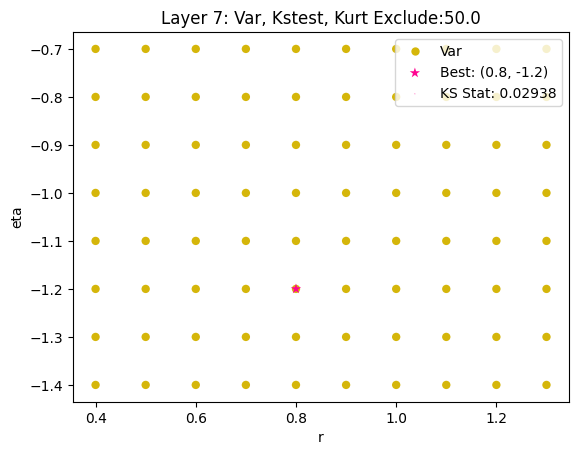

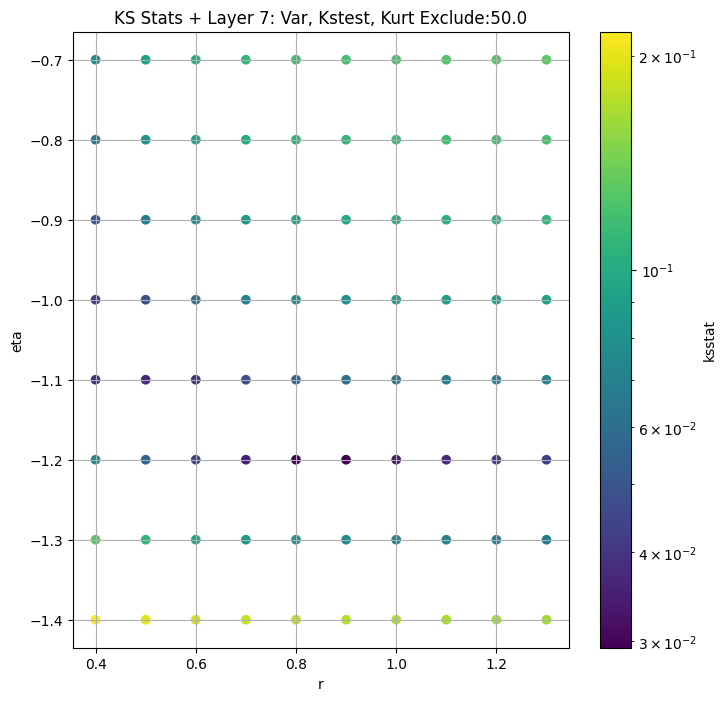

####
Layer  8


100%|██████████| 12760/12760 [03:02<00:00, 69.84it/s] 


Finding Minimum after computing 12760 CDFs
8 0 0.030479999999940777 1124.6721


100%|██████████| 12760/12760 [07:35<00:00, 28.00it/s] 


Finding Minimum after computing 12760 CDFs
8 25 0.030479999999939 1062.7264


100%|██████████| 12760/12760 [01:01<00:00, 209.03it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.03047999999993778 1019.6952


100%|██████████| 12760/12760 [00:57<00:00, 223.17it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.030479999999936724 984.29114


100%|██████████| 12760/12760 [00:59<00:00, 215.37it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.030479999999935614 953.68243


100%|██████████| 12760/12760 [00:58<00:00, 218.62it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.030479999999933838 901.68945


100%|██████████| 12760/12760 [00:58<00:00, 217.91it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.030479999999940555 857.9351


100%|██████████| 12760/12760 [01:10<00:00, 180.39it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.030479999999912577 819.9612


100%|██████████| 12760/12760 [01:02<00:00, 203.17it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.030479999999910745 786.2759


100%|██████████| 12760/12760 [01:08<00:00, 186.00it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.030479999999908858 755.94745


100%|██████████| 12760/12760 [00:57<00:00, 221.54it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.030479999999903973 679.53156
Number of samples: 100000, Without approximation : 6569984.0


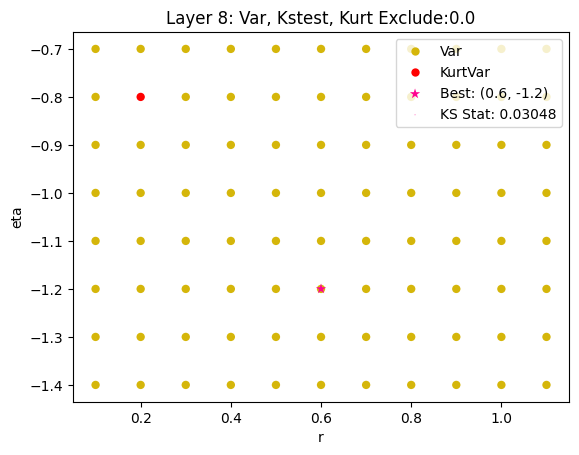

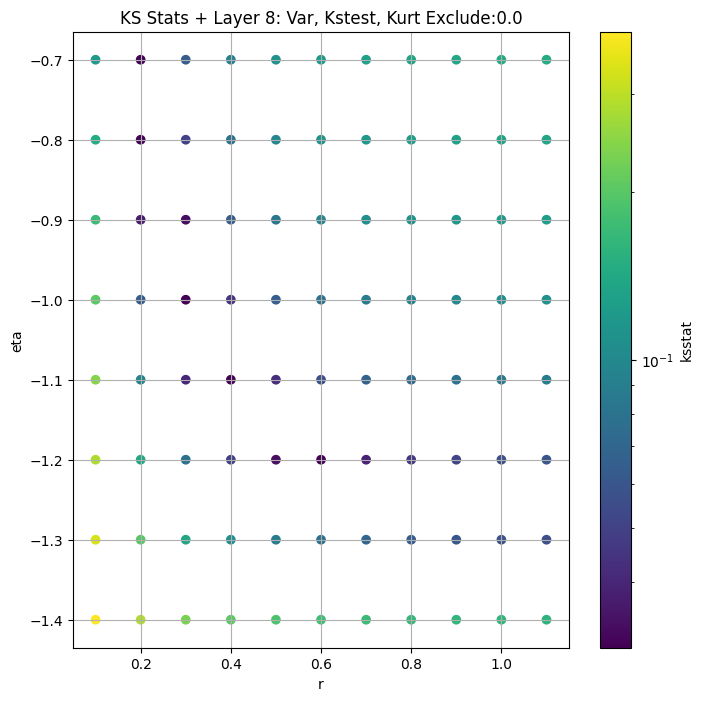

####
Layer  9


100%|██████████| 12760/12760 [00:59<00:00, 214.32it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.061049999997088156 243.90544


100%|██████████| 12760/12760 [00:58<00:00, 218.31it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.061049999996984516 227.44418


100%|██████████| 12760/12760 [01:00<00:00, 212.08it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.061049999996907356 216.22404


100%|██████████| 12760/12760 [00:59<00:00, 215.67it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.06104999999683974 207.06696


100%|██████████| 12760/12760 [00:58<00:00, 217.87it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.061049999996778126 199.21704


100%|██████████| 12760/12760 [00:58<00:00, 219.41it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.061049999997161375 186.1261


100%|██████████| 12760/12760 [00:56<00:00, 225.69it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.061049999997075555 175.36488


100%|██████████| 12760/12760 [00:57<00:00, 223.02it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.061049999996995785 166.17947


100%|██████████| 12760/12760 [01:01<00:00, 208.34it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.06104999999692062 158.15851


100%|██████████| 12760/12760 [00:58<00:00, 219.39it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.0610499999968489 151.04346


100%|██████████| 12760/12760 [01:11<00:00, 179.69it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.061049999996832416 133.57626
Number of samples: 100000, Without approximation : 26279936.0


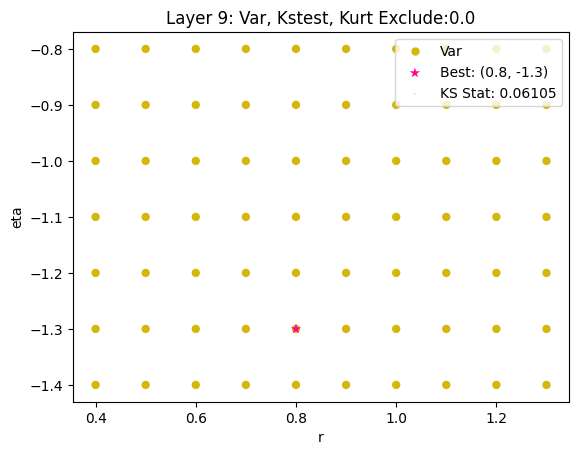

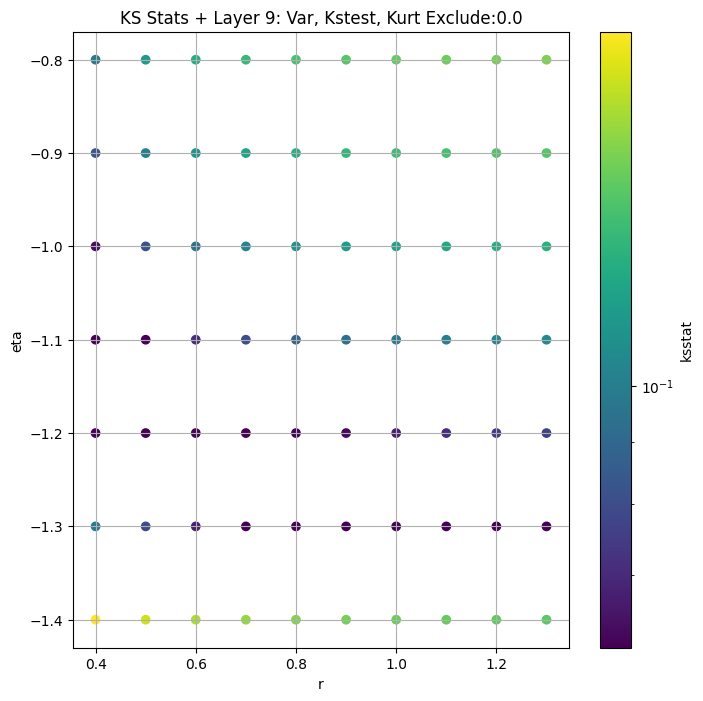

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.873965e+07  1.663401e+07  2.101433e+07   1.273592    0.505800   
3      4.449792e+06  4.165360e+06  4.741460e+06   2.060963    1.628771   
4      9.473083e+05  8.903944e+05  1.005686e+06   3.505688    2.952087   
5      1.869647e+05  1.740690e+05  2.004473e+05   5.608747    4.736248   
6      3.371252e+04  3.086009e+04  3.671613e+04   9.509533    7.824300   
7      5.919651e+03  5.323679e+03  6.567964e+03  14.504868   11.675694   
8      1.124672e+03  9.873868e+02  1.276368e+03  22.566565   17.524040   
9      2.439054e+02  2.100613e+02  2.812192e+02  30.251938   22.803614   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.174329         1604.0             0.011798        0.4          4.4   
3        2.520827         6416.0             0.010687        0.4          0.9   
4        4.137850        25664.0             0.009794        0.4         -0.1   
5        6.600736       102656.0             0.008674        0.5         -0.8   
6       11.492226       410624.0             0.014160        0.5         -1.0   
7       18.431257      1642496.0             0.029376        0.8         -1.2   
8       29.029783      6569984.0             0.030480        0.6         -1.2   
9       40.821050     26279936.0             0.061050        0.8         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       19857.387313                     0.0        1.873965e+07   
3       38047.566159                     0.0        4.449792e+06   
4       26235.316664                     0.0        9.473083e+05   
5       55644.247582                     0.0        1.869647e+05   
6       15650.207031                    75.0        3.130041e+04   
7       14582.913414                    50.0        5.515721e+03   
8        1841.778794                     0.0        1.124672e+03   
9         997.832450                     0.0        2.439054e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [15]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [16]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 792/792 [00:00<00:00, 1640.49it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08041927454085715, var: 9082016.0


100%|██████████| 792/792 [00:00<00:00, 4946.57it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06581939352535512, var: 10410673.0


100%|██████████| 792/792 [00:00<00:00, 5464.70it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05091442548875656, var: 12047654.0


100%|██████████| 792/792 [00:00<00:00, 7141.77it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.035231797486131616, var: 14204823.0


100%|██████████| 792/792 [00:00<00:00, 6950.36it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.011739915829683367, var: 18739654.0
Number of samples: 1604, Without approximation : 1604.0


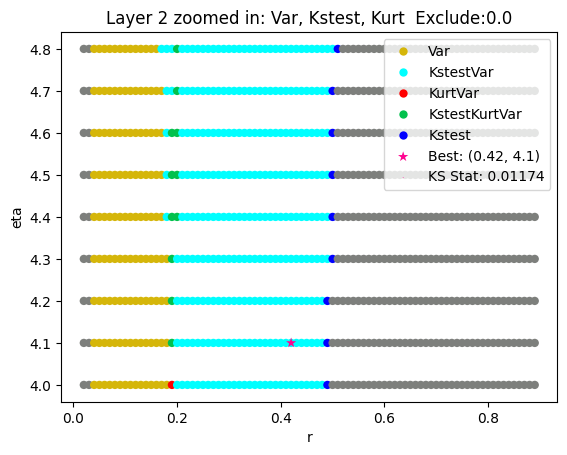

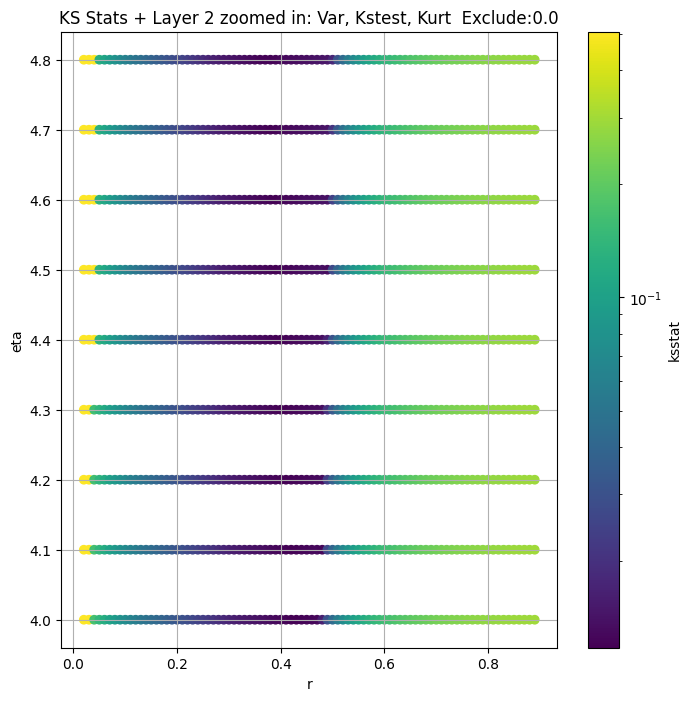

Layer 3


100%|██████████| 880/880 [00:00<00:00, 1488.37it/s]


Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.030766914540369505, var: 3218716.0


100%|██████████| 880/880 [00:00<00:00, 2953.19it/s]


Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.025681623395168218, var: 3421328.75


100%|██████████| 880/880 [00:00<00:00, 2959.30it/s]


Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.020217720286205026, var: 3658305.25


100%|██████████| 880/880 [00:00<00:00, 2664.58it/s]


Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.014504284298992642, var: 3959553.5


100%|██████████| 880/880 [00:00<00:00, 2758.87it/s]


Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.01022151967768592, var: 4449792.0
Number of samples: 6416, Without approximation : 6416.0


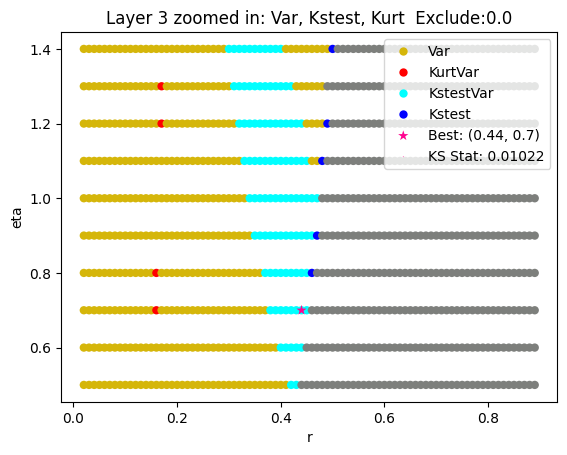

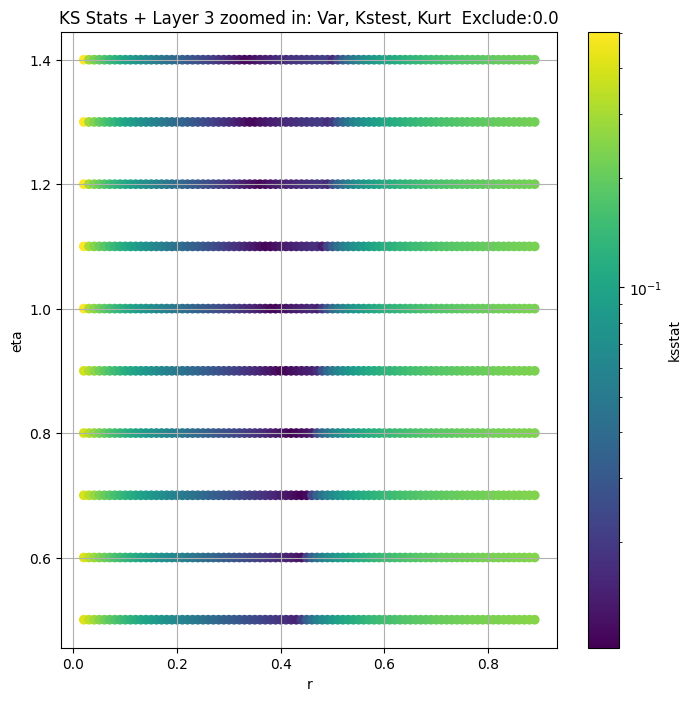

Layer 4


100%|██████████| 1224/1224 [00:02<00:00, 576.03it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.014422627641308194, var: 817522.375


100%|██████████| 1224/1224 [00:01<00:00, 810.52it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.013200442232169096, var: 841726.8125


100%|██████████| 1224/1224 [00:01<00:00, 725.98it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.01182938743378037, var: 868989.0625


100%|██████████| 1224/1224 [00:01<00:00, 720.73it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.010551449374365696, var: 901307.125


100%|██████████| 1224/1224 [00:01<00:00, 725.70it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.00850741372078656, var: 947308.3125
Number of samples: 25664, Without approximation : 25664.0


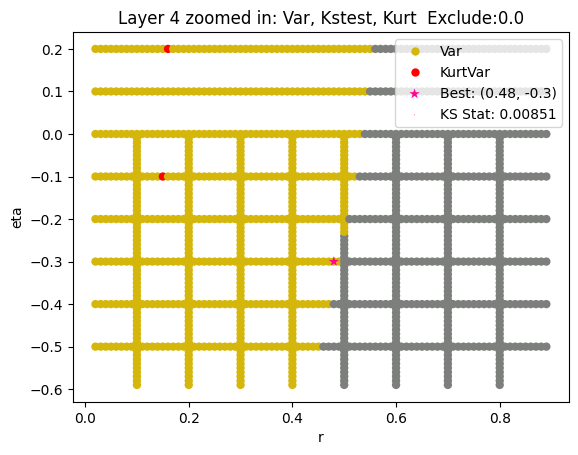

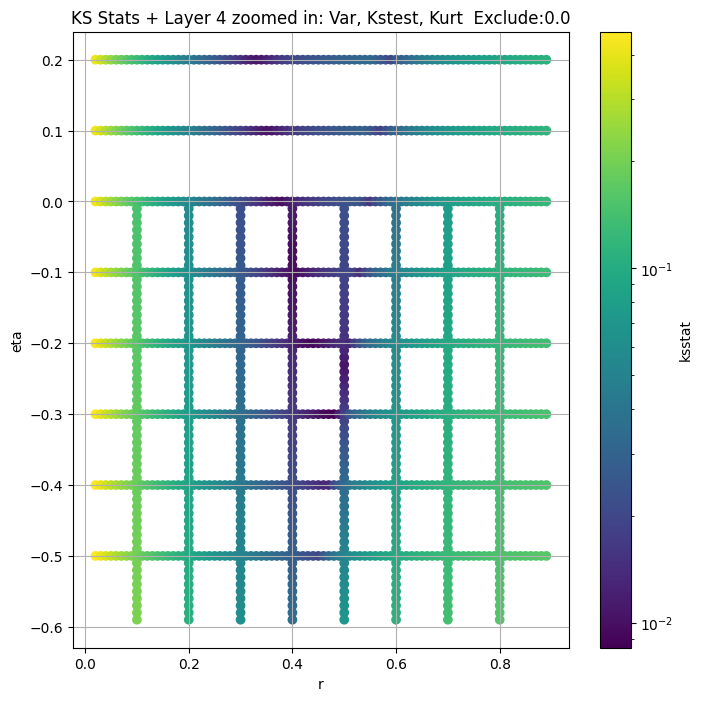

Layer 5


100%|██████████| 1692/1692 [00:08<00:00, 191.83it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.009695879758787385, var: 175148.96875


100%|██████████| 1692/1692 [00:10<00:00, 155.61it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.009410228083650884, var: 177533.546875


100%|██████████| 1692/1692 [00:12<00:00, 137.54it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.009085869340176855, var: 180148.796875


100%|██████████| 1692/1692 [00:11<00:00, 148.82it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.008687673593627543, var: 183123.375


100%|██████████| 1692/1692 [00:11<00:00, 147.30it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.007816102238119127, var: 186964.671875
Number of samples: 100000, Without approximation : 102656.0


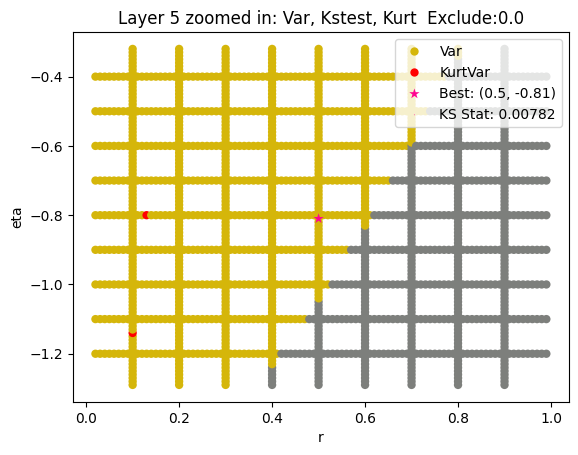

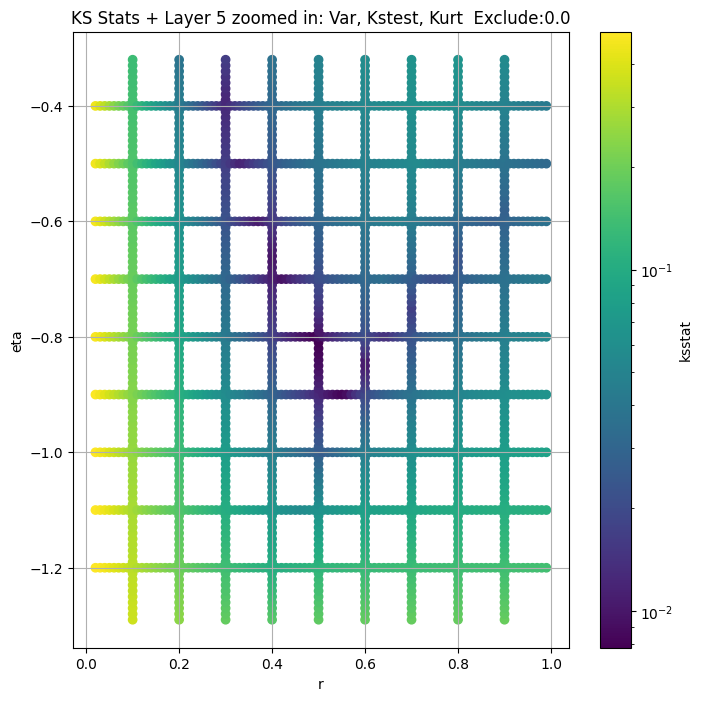

Layer 6


100%|██████████| 1656/1656 [00:10<00:00, 163.13it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + 100 = 175, ksstat: 0.014021473275328211, var: 29282.412109375


100%|██████████| 1656/1656 [00:08<00:00, 205.57it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + 75 = 150, ksstat: 0.013834491169385288, var: 29731.275390625


100%|██████████| 1656/1656 [00:11<00:00, 138.83it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + 50 = 125, ksstat: 0.01412611929825125, var: 30210.0


100%|██████████| 1656/1656 [00:13<00:00, 124.57it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + 25 = 100, ksstat: 0.014264369840110869, var: 30729.126953125


100%|██████████| 1656/1656 [00:07<00:00, 216.31it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + 0 = 75, ksstat: 0.014159500051316276, var: 31300.4140625


100%|██████████| 1656/1656 [00:10<00:00, 154.67it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + -25 = 50, ksstat: 0.014414507558526468, var: 31940.552734375


100%|██████████| 1656/1656 [00:08<00:00, 204.35it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + -50 = 25, ksstat: 0.01419138331138603, var: 32690.78515625


100%|██████████| 1656/1656 [00:11<00:00, 146.69it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 75.0 + -75 = 0, ksstat: 0.014270465650715602, var: 33712.515625
Number of samples: 100000, Without approximation : 410624.0


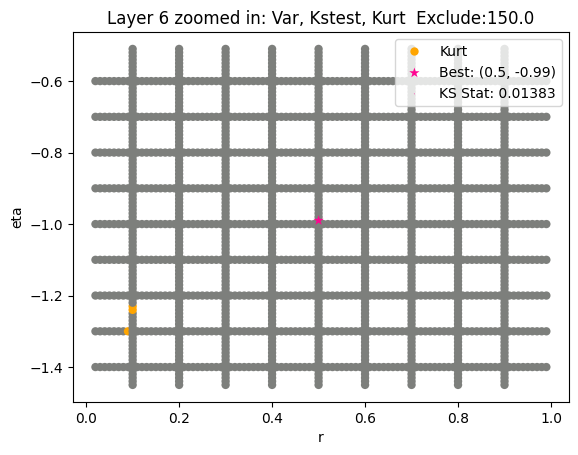

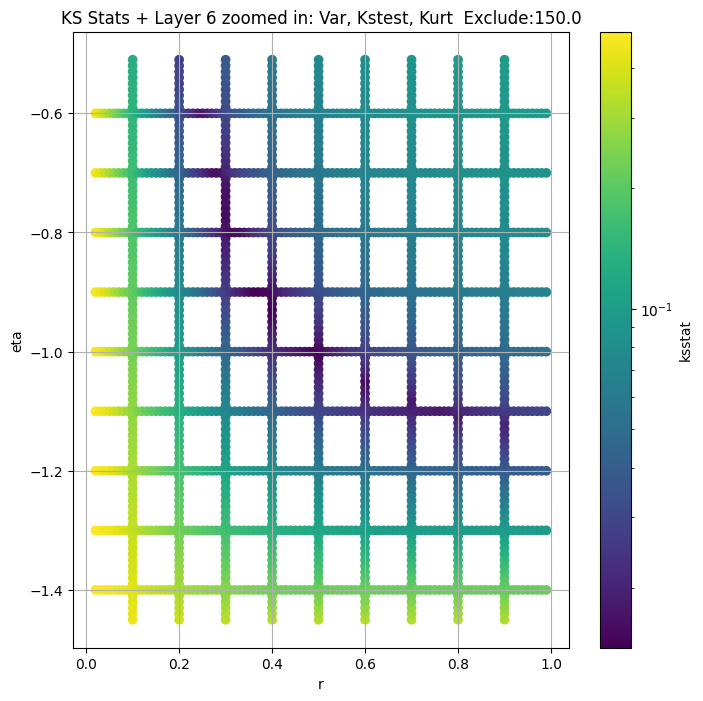

Layer 7


100%|██████████| 1305/1305 [00:09<00:00, 138.96it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.02937533446058066, var: 5026.24462890625


100%|██████████| 1305/1305 [00:05<00:00, 219.23it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.029376736364595313, var: 5131.025390625


100%|██████████| 1305/1305 [00:05<00:00, 218.11it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.02937551798721799, var: 5245.53515625


100%|██████████| 1305/1305 [00:06<00:00, 202.51it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.029374302640530925, var: 5372.205078125


100%|██████████| 1305/1305 [00:05<00:00, 220.07it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.02937320184070874, var: 5515.72119140625


100%|██████████| 1305/1305 [00:05<00:00, 219.65it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.029374476748028622, var: 5683.29345703125


100%|██████████| 1305/1305 [00:06<00:00, 212.86it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.02937328491771446, var: 5919.6513671875
Number of samples: 100000, Without approximation : 1642496.0


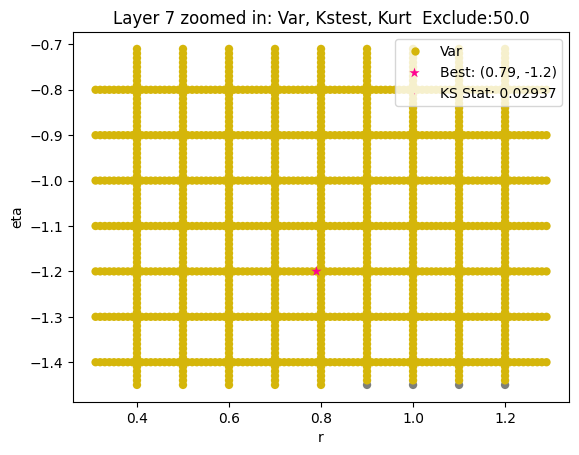

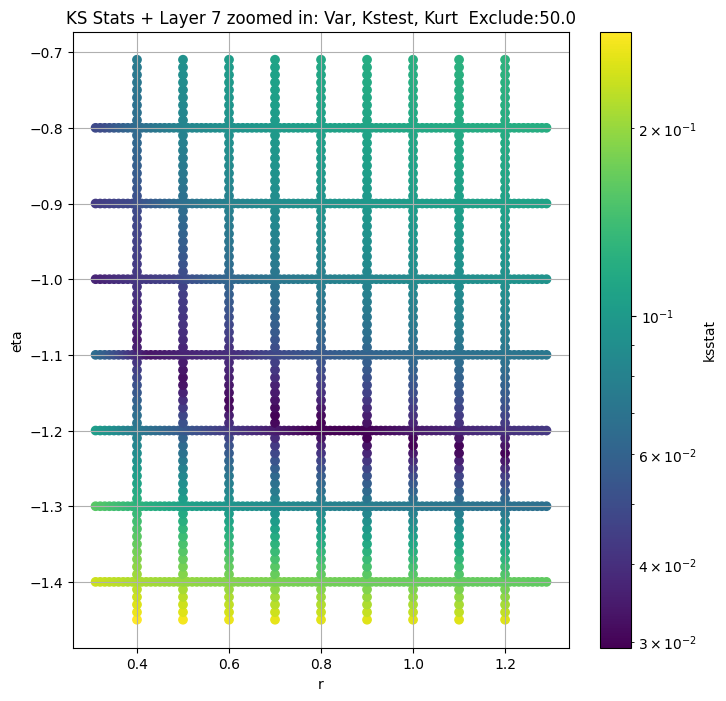

Layer 8


100%|██████████| 1305/1305 [00:05<00:00, 220.60it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.03047999999967599, var: 953.6824340820312


100%|██████████| 1305/1305 [00:05<00:00, 219.81it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.030479999999721563, var: 984.2911376953125


100%|██████████| 1305/1305 [00:06<00:00, 208.83it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.030479999999894203, var: 1019.6951904296875


100%|██████████| 1305/1305 [00:06<00:00, 216.72it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.030479999999894092, var: 1062.7264404296875


100%|██████████| 1305/1305 [00:06<00:00, 203.85it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.030479999999712848, var: 1124.672119140625
Number of samples: 100000, Without approximation : 6569984.0


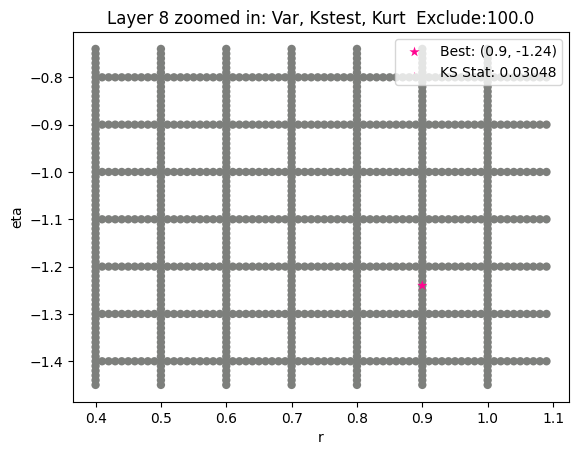

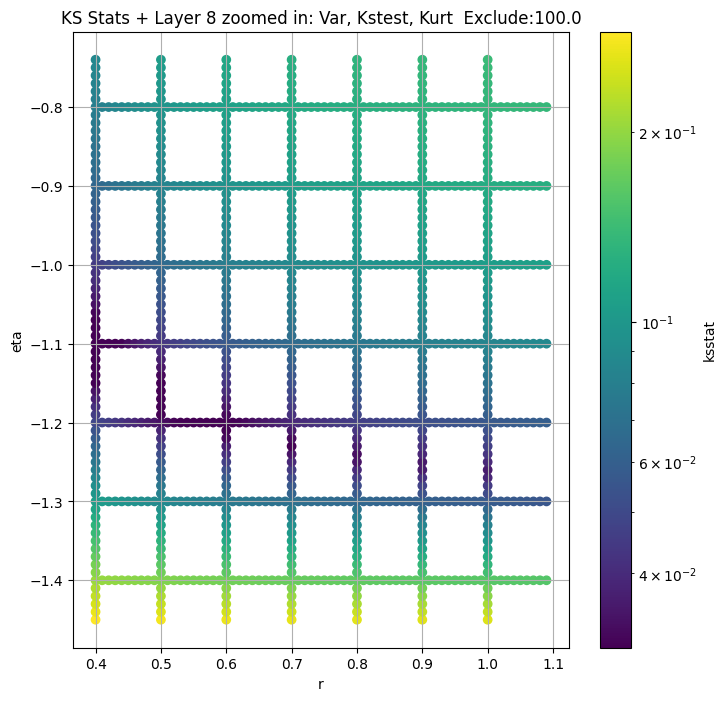

Layer 9


100%|██████████| 1125/1125 [00:05<00:00, 207.64it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.06104999999675176, var: 199.217041015625


100%|██████████| 1125/1125 [00:05<00:00, 208.67it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.061049999996758975, var: 207.06695556640625


100%|██████████| 1125/1125 [00:05<00:00, 199.59it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.0610499999967386, var: 216.2240447998047


100%|██████████| 1125/1125 [00:05<00:00, 219.53it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.06104999999675492, var: 227.44418334960938


100%|██████████| 1125/1125 [00:05<00:00, 222.08it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.061049999996760584, var: 243.9054412841797
Number of samples: 100000, Without approximation : 26279936.0


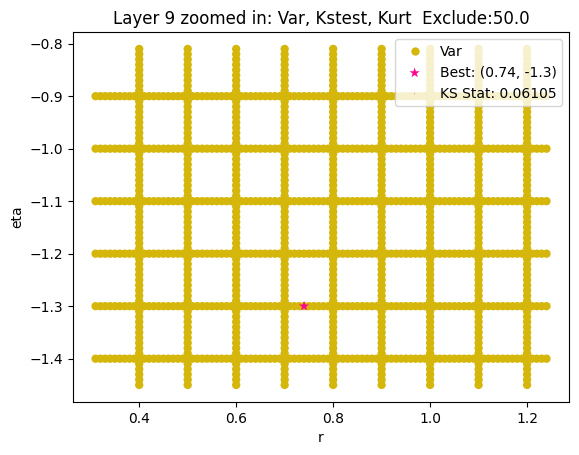

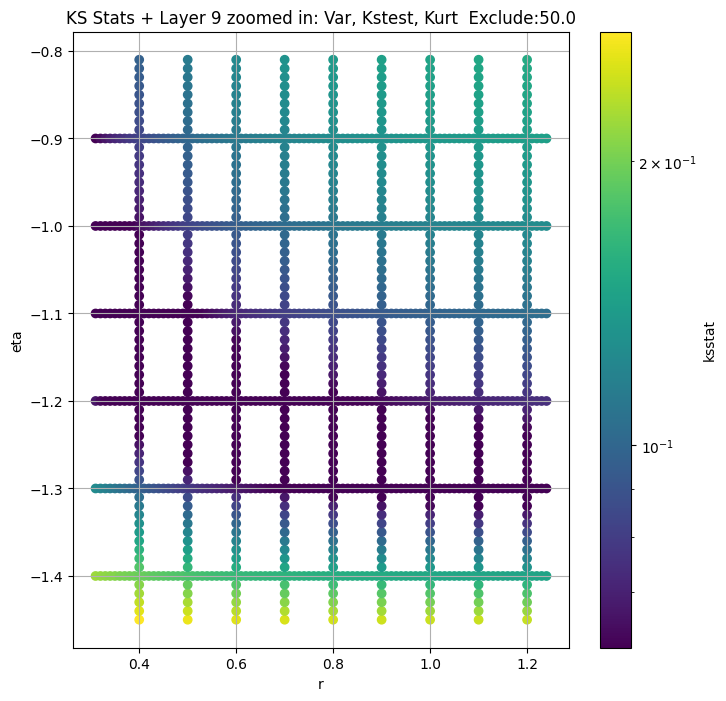

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.873965e+07  1.663401e+07  2.101433e+07   1.273592    0.505800   
3      4.449792e+06  4.165360e+06  4.741460e+06   2.060963    1.628771   
4      9.473083e+05  8.903944e+05  1.005686e+06   3.505688    2.952087   
5      1.869647e+05  1.740690e+05  2.004473e+05   5.608747    4.736248   
6      3.371252e+04  3.086009e+04  3.671613e+04   9.509533    7.824300   
7      5.919651e+03  5.323679e+03  6.567964e+03  14.504868   11.675694   
8      1.124672e+03  9.873868e+02  1.276368e+03  22.566565   17.524040   
9      2.439054e+02  2.100613e+02  2.812192e+02  30.251938   22.803614   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.174329         1604.0             0.011798        0.4          4.4   
3        2.520827         6416.0             0.010687        0.4          0.9   
4        4.137850        25664.0             0.009794        0.4         -0.1   
5        6.600736       102656.0             0.008674        0.5         -0.8   
6       11.492226       410624.0             0.014160        0.5         -1.0   
7       18.431257      1642496.0             0.029376        0.8         -1.2   
8       29.029783      6569984.0             0.030480        0.6         -1.2   
9       40.821050     26279936.0             0.061050        0.8         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       19857.387313                     0.0        1.873965e+07   
3       38047.566159                     0.0        4.449792e+06   
4       26235.316664                     0.0        9.473083e+05   
5       55644.247582                     0.0        1.869647e+05   
6       15650.207031                    75.0        2.973128e+04   
7       14582.913414                    50.0        5.515721e+03   
8        1841.778794                     0.0        9.536824e+02   
9         997.832450                     0.0        2.162240e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.011740    0.42      4.10   
3                     0.016929          0.010222    0.44      0.70   
4                     0.008471          0.008507    0.48     -0.30   
5                     0.004237          0.007816    0.50     -0.81   
6                     0.002119          0.013834    0.50     -0.99   
7                     0.001060          0.029373    0.79     -1.20   
8                     0.000530          0.030480    0.90     -1.24   
9                     0.000265          0.061050    0.74     -1.30   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      34926.283238                  0.0      13699.0  
3      88501.850770                  0.0      18270.0  
4      96348.700908                  0.0      25664.0  
5      56925.061465                  0.0      28872.0  
6      14429.856043                150.0       9624.0  
7      14348.742474                 50.0       2029.0  
8       3345.703166                100.0       2029.0  
9        805.671947                 50.0        505.0

In [17]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

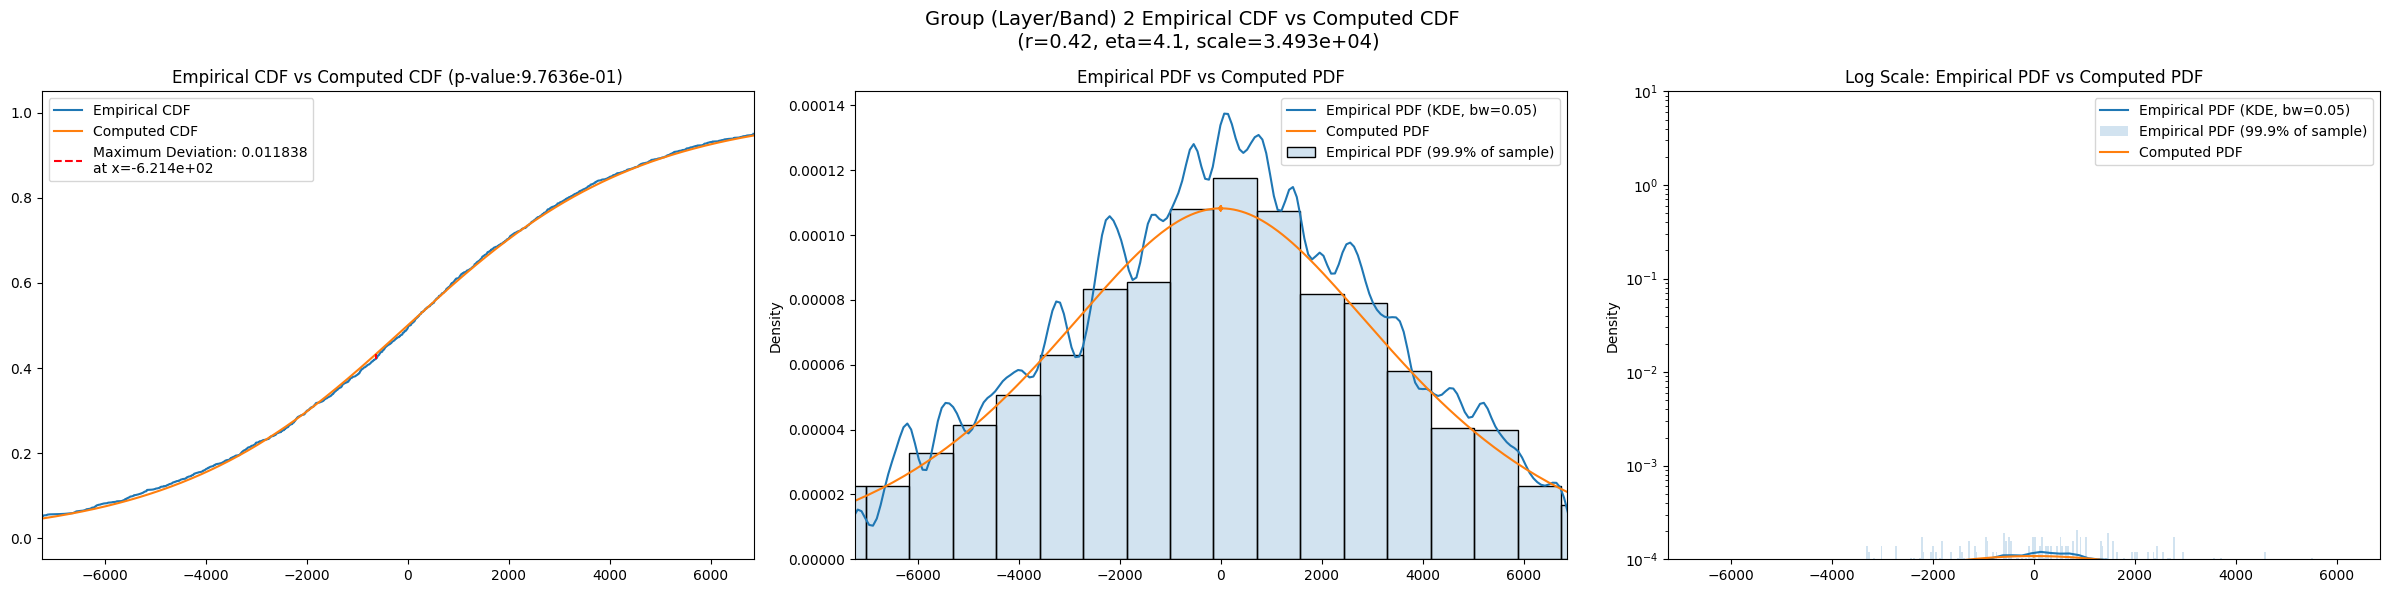

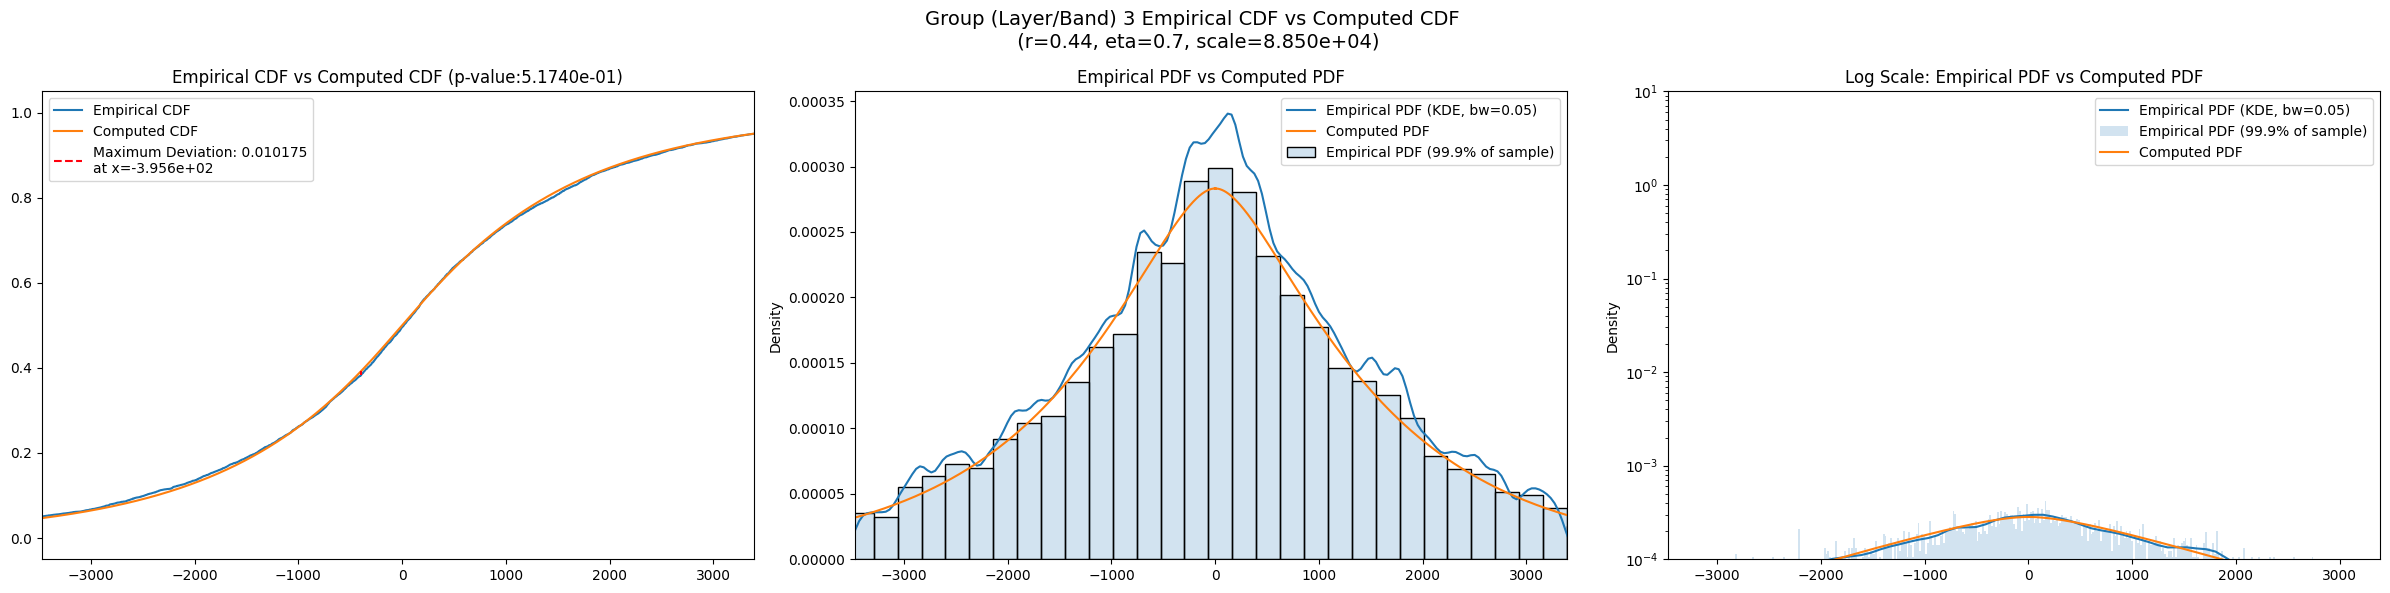

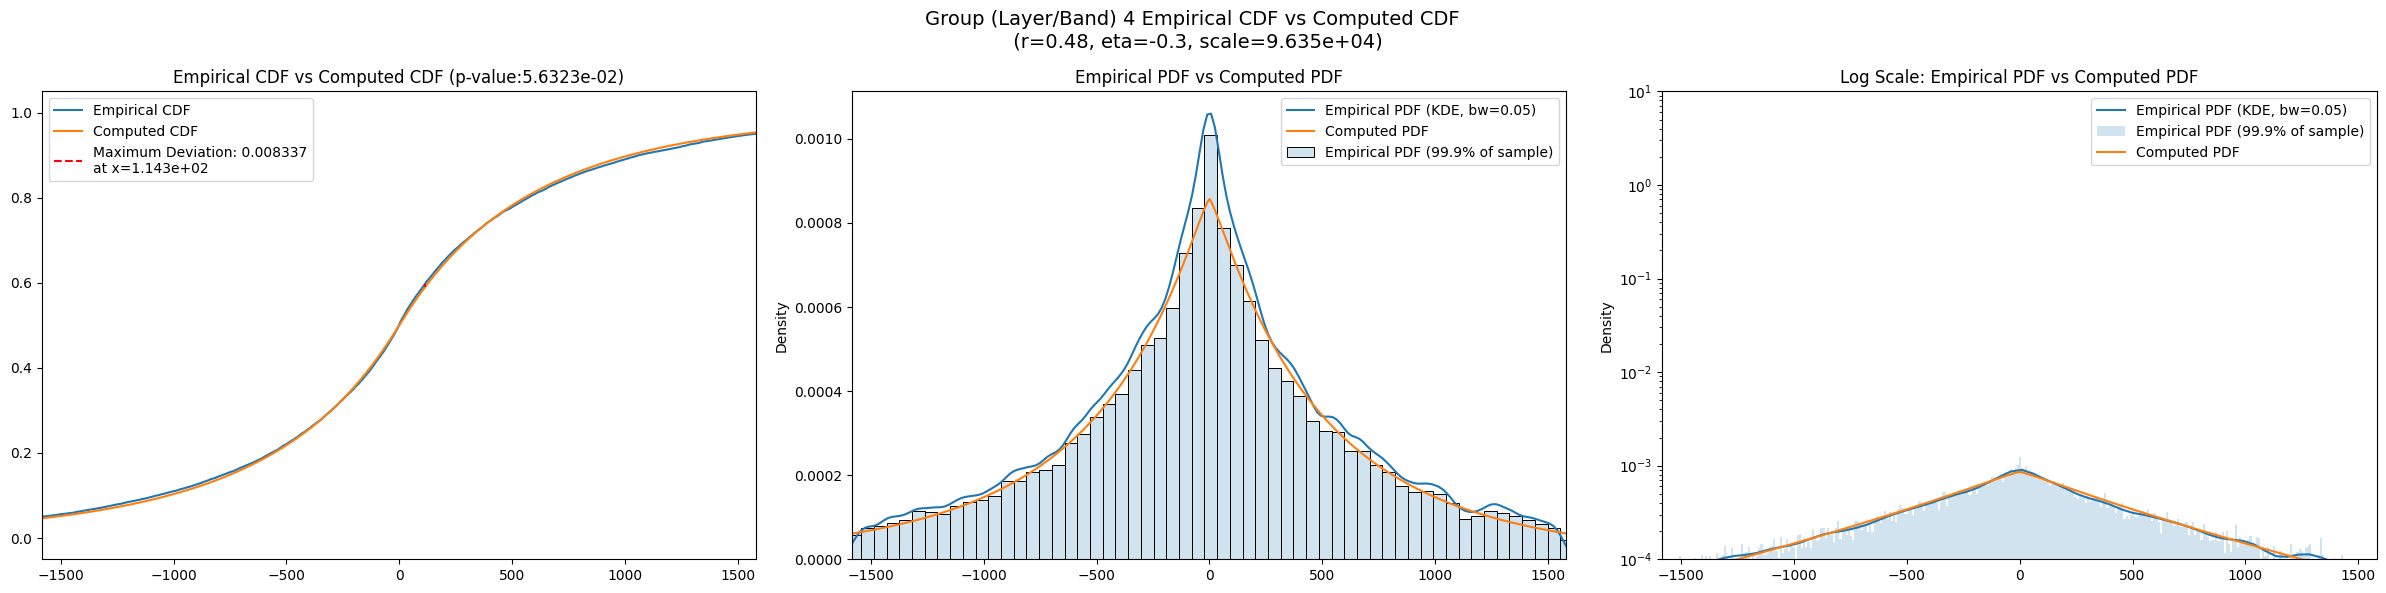

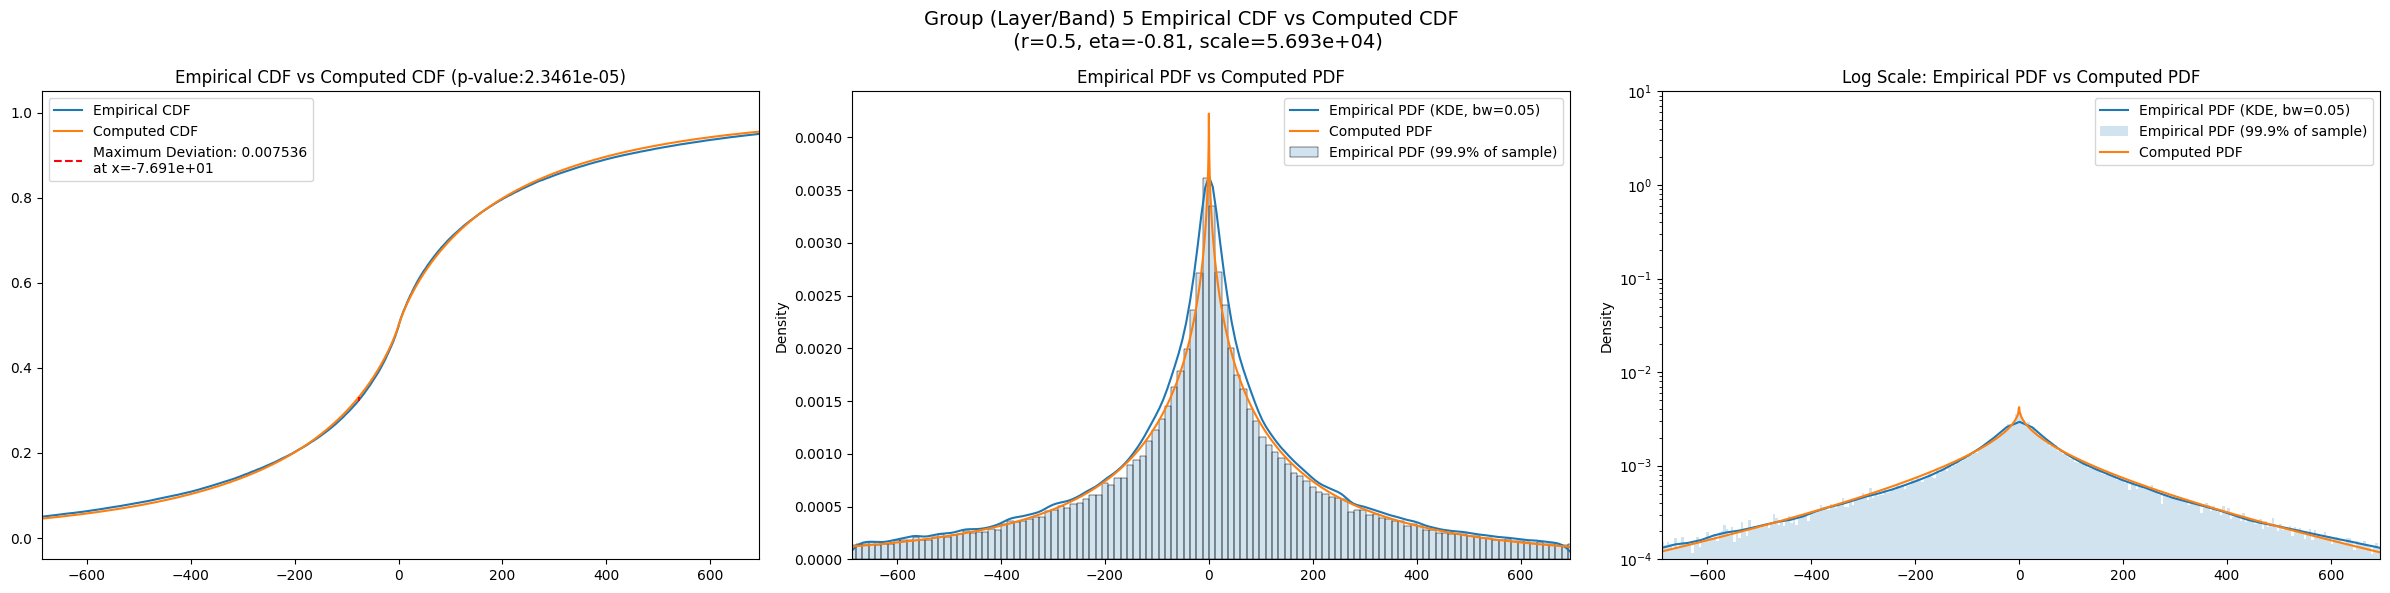

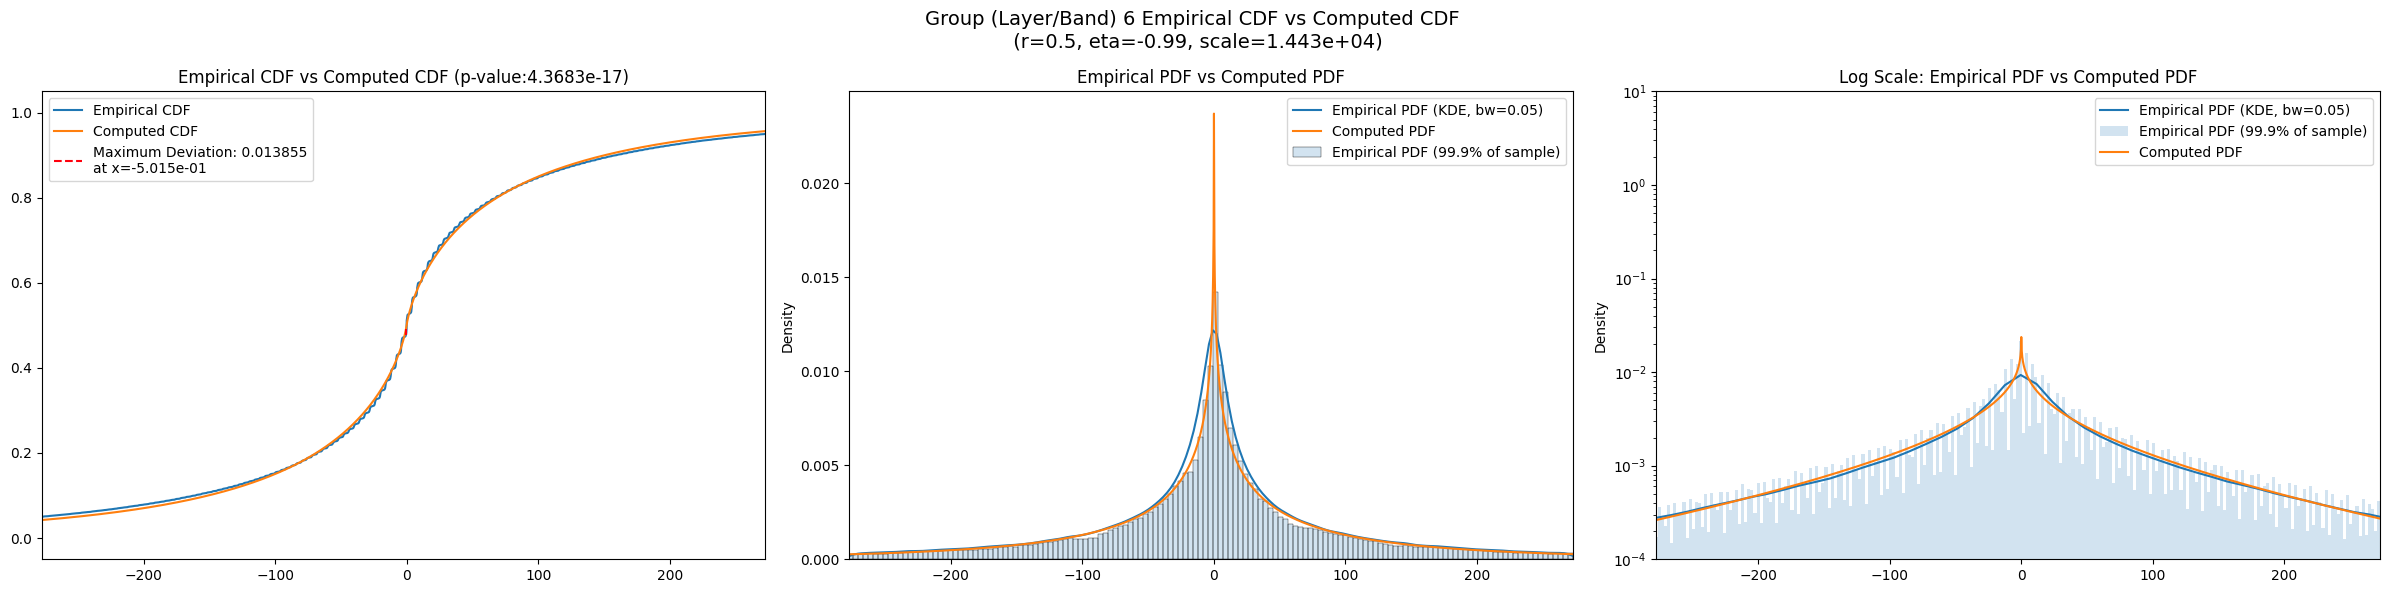

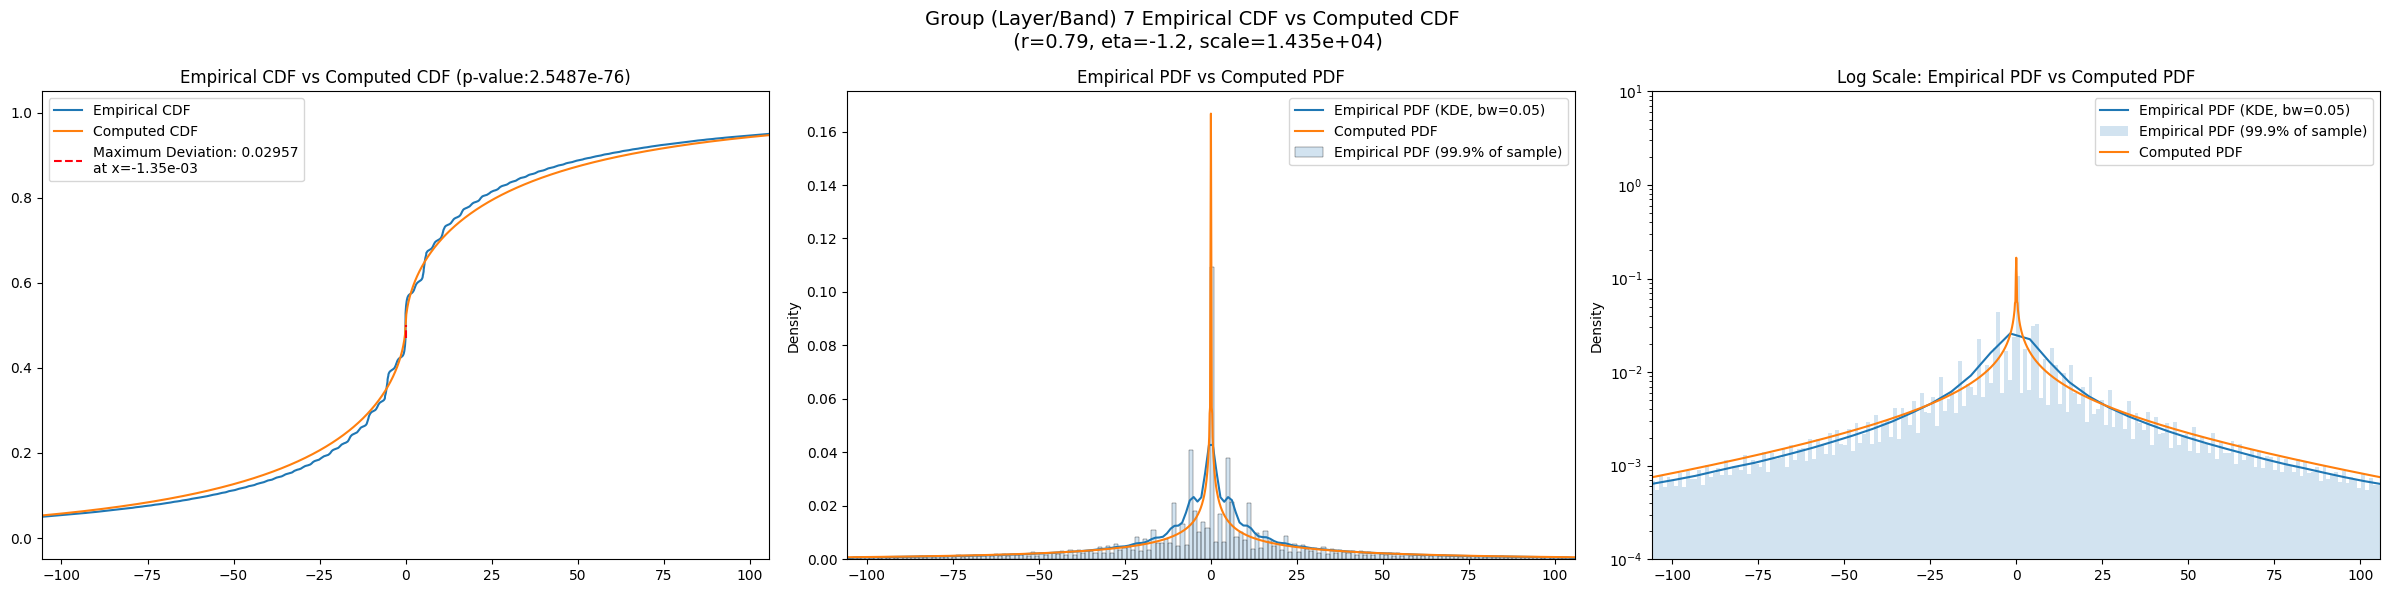

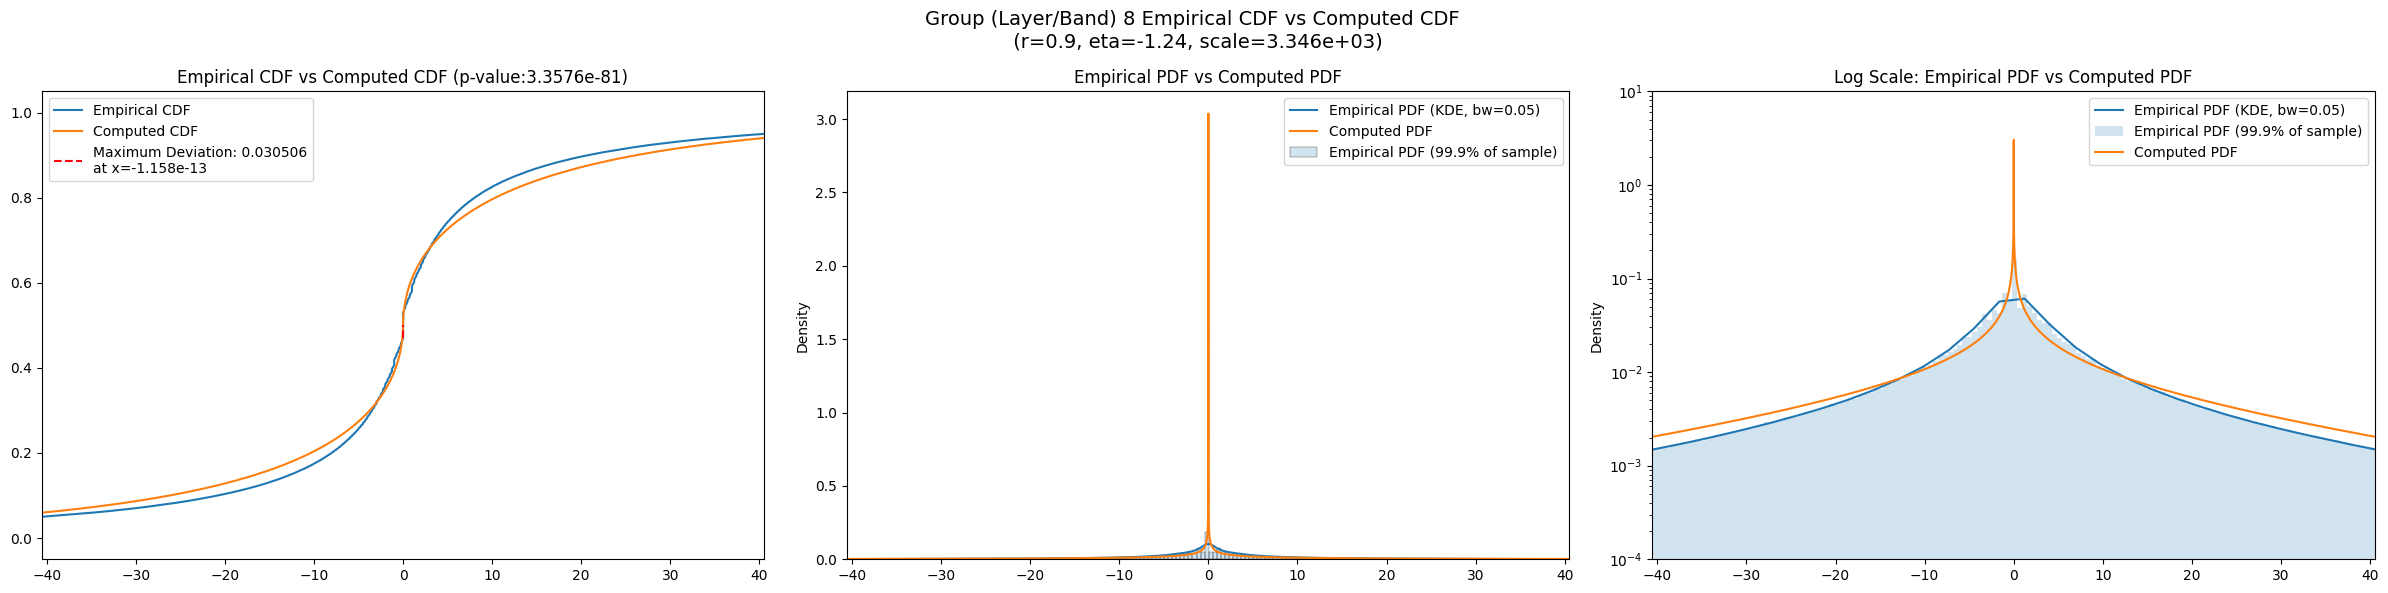

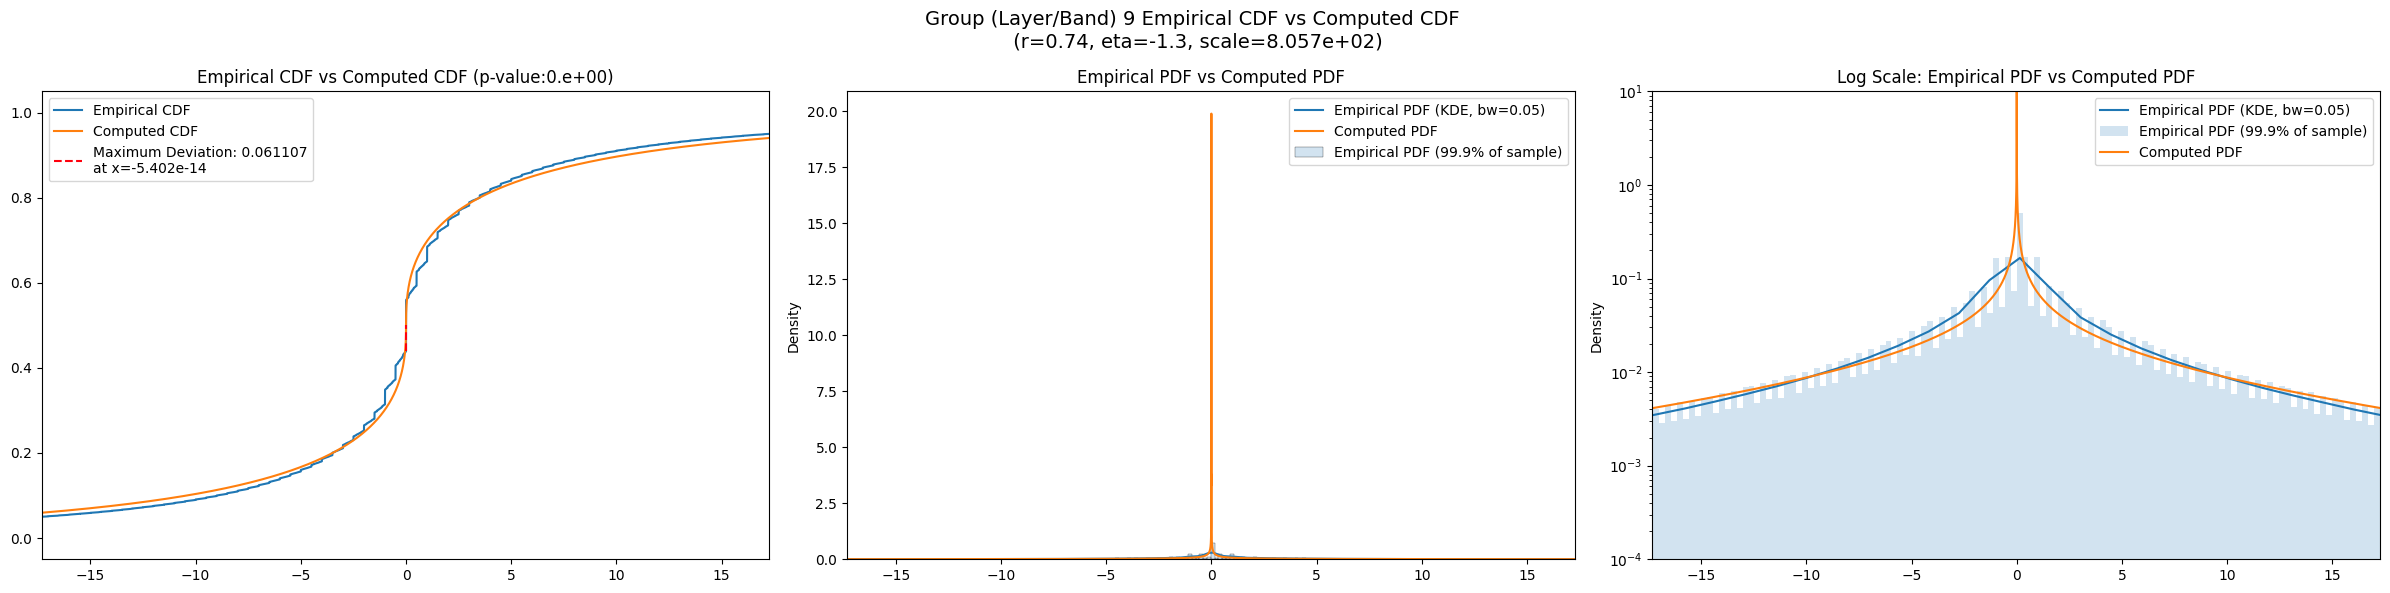

In [18]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [19]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [20]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.873965e+07  1.663401e+07  2.101433e+07   1.273592    0.505800   
3      4.449792e+06  4.165360e+06  4.741460e+06   2.060963    1.628771   
4      9.473083e+05  8.903944e+05  1.005686e+06   3.505688    2.952087   
5      1.869647e+05  1.740690e+05  2.004473e+05   5.608747    4.736248   
6      3.371252e+04  3.086009e+04  3.671613e+04   9.509533    7.824300   
7      5.919651e+03  5.323679e+03  6.567964e+03  14.504868   11.675694   
8      1.124672e+03  9.873868e+02  1.276368e+03  22.566565   17.524040   
9      2.439054e+02  2.100613e+02  2.812192e+02  30.251938   22.803614   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.174329         1604.0             0.011798        0.4          4.4   
3        2.520827         6416.0             0.010687        0.4          0.9   
4        4.137850        25664.0             0.009794        0.4         -0.1   
5        6.600736       102656.0             0.008674        0.5         -0.8   
6       11.492226       410624.0             0.014160        0.5         -1.0   
7       18.431257      1642496.0             0.029376        0.8         -1.2   
8       29.029783      6569984.0             0.030480        0.6         -1.2   
9       40.821050     26279936.0             0.061050        0.8         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      4005.26000              0.018577          6.303460e-01   
3      ...      1738.47000              0.028634          5.284020e-05   
4      ...       708.56100              0.041726          2.903550e-39   
5      ...       256.44000              0.058745                   NaN   
6      ...        84.22310              0.073495          0.000000e+00   
7      ...        26.95740              0.083688          0.000000e+00   
8      ...        10.80580              0.075060          0.000000e+00   
9      ...         4.04735              0.087815          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         3493.33000             0.020117         5.282430e-01  2834.12000   
3         1557.56000             0.007536         8.566340e-01  1276.03000   
4          618.38600             0.014589         3.566120e-05   504.32100   
5          223.11700             0.031452         1.166140e-88   177.45300   
6           72.54140             0.047631         0.000000e+00    56.95830   
7           23.31690             0.058051         0.000000e+00    18.24110   
8            9.48292             0.049739         0.000000e+00     7.27683   
9            3.52239             0.061812         0.000000e+00     2.72281   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.024334   2.935000e-01          9.780746e-01  
3           0.013940   1.635970e-01          5.106779e-01  
4           0.018808   2.570680e-08          4.843725e-02  
5           0.034094  4.168070e-104          7.102843e-06  
6           0.049006   0.000000e+00          1.074516e-68  
7           0.058120   0.000000e+00          0.000000e+00  
8           0.048586   0.000000e+00          0.000000e+00  
9           0.062702   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [21]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [22]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.011798                 0.033804          0.011740   
3                 0.010687                 0.016929          0.010222   
4                 0.009794                 0.008471          0.008507   
5                 0.008674                 0.004237          0.007816   
6                 0.014160                 0.002119          0.013834   
7                 0.029376                 0.001060          0.029373   
8                 0.030480                 0.000530          0.030480   
9                 0.061050                 0.000265          0.061050   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.018577             0.020117       0.024334  
3                  0.028634             0.007536       0.013940  
4                  0.041726             0.014589       0.018808  
5                  0.058745             0.031452       0.034094  
6                  0.073495             0.047631       0.049006  
7                  0.083688             0.058051       0.058120  
8                  0.075060             0.049739       0.048586  
9                  0.087815             0.061812       0.062702

In [23]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            1.873965e+07          0.011740    0.42      4.10  34926.283238   
3            4.449792e+06          0.010222    0.44      0.70  88501.850770   
4            9.473083e+05          0.008507    0.48     -0.30  96348.700908   
5            1.869647e+05          0.007816    0.50     -0.81  56925.061465   
6            2.973128e+04          0.013834    0.50     -0.99  14429.856043   
7            5.515721e+03          0.029373    0.79     -1.20  14348.742474   
8            9.536824e+02          0.030480    0.90     -1.24   3345.703166   
9            2.162240e+02          0.061050    0.74     -1.30    805.671947   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    150.0  
7                     50.0  
8                    100.0  
9                     50.0

In [24]:
eng.quit()